# Recurrent artificial neural networks
# Long Short-Term Memory - LSTM
--------

This notebook will guide you through the training and testing of a LSTM network in the task of predicting the speed of a runner for a given slope by using her/his previous speeds during a given race.

Before running the cells in this notebook you have to upload some files with data from some races and the Python module for parsing those files and preparing a dataset.
### left panel -> Files -> Upload
Then select the compressed folder **strava.zip** and the Python module **strava.py**

### OR
Uncomment and update the code in the following cell if your data is in your google drive

In [1]:
#from google.colab import drive
#drive.mount('/content/drive')

#!cp 'drive/My Drive/Colab Notebooks/strava.zip' .
#!cp 'drive/My Drive/Colab Notebooks/strava.py' .

Let us start by loading some Python modules

In [2]:
import numpy as np
from matplotlib import pyplot as pl
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import os

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

import strava as st

Then, let us unzip the compressed file you uploaded

In [3]:
if os.path.exists('strava'):
  print('Data are already in folder')
else:
  if os.path.exists('strava.zip'):
    !unzip strava.zip
  else:
    print('You must upload the data first!')

Archive:  strava.zip
   creating: strava/
  inflating: strava/20111004-161158-Run.tab  
   creating: __MACOSX/
   creating: __MACOSX/strava/
  inflating: __MACOSX/strava/._20111004-161158-Run.tab  
  inflating: strava/20111008-153459-Run.tab  
  inflating: __MACOSX/strava/._20111008-153459-Run.tab  
  inflating: strava/20111012-153536-Run.tab  
  inflating: __MACOSX/strava/._20111012-153536-Run.tab  
  inflating: strava/20111015-065702-Run.tab  
  inflating: __MACOSX/strava/._20111015-065702-Run.tab  
  inflating: strava/20111018-163550-Run.tab  
  inflating: __MACOSX/strava/._20111018-163550-Run.tab  
  inflating: strava/20111023-082331-Run.tab  
  inflating: __MACOSX/strava/._20111023-082331-Run.tab  
  inflating: strava/20111027-091112-Run.tab  
  inflating: __MACOSX/strava/._20111027-091112-Run.tab  
  inflating: strava/20111030-100105-Run.tab  
  inflating: __MACOSX/strava/._20111030-100105-Run.tab  
  inflating: strava/20111105-081419-Run.tab  
  inflating: __MACOSX/strava/._2011

Declare some constants

In [4]:
PATH_DATA = 'strava'

FEATURES = ['time', 'speed', 'slope']    # selected from ['time', 'elevation', 'distance', 'speed', 'slope']
SPEED_OUTLIER = 8.0                      # speed > 30km/h
SLOPE_OUTLIER = 80                       # slope > +-80%
TIME_PERIOD = 1*60                       # period of time to average
SEGMENT_LENGTH = 100                     # length of the segment to average data
AVERAGE_SPEED_TH = 2.4                   # threshold to further clean the dataset

### Read the data
Parse the files in the **strava** folder

In [5]:
importer = st.RunImport(SPEED_OUTLIER, SLOPE_OUTLIER, TIME_PERIOD, SEGMENT_LENGTH, AVERAGE_SPEED_TH)
dataset = importer.import_path(PATH_DATA)

processing 20130901-094036-Run.tab
processing 20111112-171845-Run.tab
processing 20131024-153325-Run.tab


/content/strava.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(data)
/content/strava.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(data)


processing 20150913-125712-Run.tab

Race 2 ignored. Average speed: 1.7937603119884309
processing 20150328-160207-Run.tab

Race 2 ignored. Average speed: 1.5282285589053999
processing 20120225-155807-Run.tab


/content/strava.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(data)
/content/strava.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(data)


processing 20160309-152550-Run.tab
processing 20151004-060459-Run.tab


/content/strava.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(data)
/content/strava.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(data)


processing 20150804-222003-Run.tab
processing 20151025-130239-Run.tab


/content/strava.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(data)


processing 20150531-045613-Run.tab


/content/strava.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(data)
/content/strava.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(data)


processing 20150610-185348-Run.tab
processing 20150315-104457-Run.tab


/content/strava.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(data)


processing 20131027-130016-Run.tab


/content/strava.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(data)
/content/strava.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(data)


processing 20111027-091112-Run.tab
processing 20130105-101007-Run.tab


/content/strava.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(data)
/content/strava.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(data)


processing 20130514-192730-Run.tab
processing 20130908-091444-Run.tab


/content/strava.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(data)
/content/strava.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(data)


processing 20140330-054130-Run.tab
processing 20140218-153658-Run.tab


/content/strava.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(data)


processing 20130403-153939-Run.tab

Race 17 ignored. Average speed: 1.428994705218629
processing 20111023-082331-Run.tab


/content/strava.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(data)
/content/strava.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(data)


processing 20131002-161507-Run.tab
processing 20150308-074410-Run.tab

Race 19 ignored. Average speed: 0.6834166494444333
processing 20111012-153536-Run.tab


/content/strava.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(data)
/content/strava.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(data)


processing 20130924-185800-Run.tab
processing 20150315-120227-Run.tab

Race 21 ignored. Average speed: 0.45711780989917566
processing 20150823-132029-Run.tab


/content/strava.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(data)
/content/strava.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(data)


processing 20111108-164522-Run.tab
processing 20120925-154536-Run.tab


/content/strava.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(data)
/content/strava.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(data)


processing 20131106-172441-Run.tab
processing 20130120-161034-Run.tab


/content/strava.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(data)


processing 20141116-104116-Run.tab


/content/strava.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(data)


processing 20130310-100031-Run.tab

Race 27 ignored. Average speed: 2.362651651185991
processing 20140630-193005-Run.tab


/content/strava.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(data)
/content/strava.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(data)


processing 20111115-172413-Run.tab
processing 20141224-082653-Run.tab


/content/strava.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(data)


processing 20150510-060418-Run.tab

Race 30 ignored. Average speed: 1.8827972634267185
processing 20140518-135931-Run.tab


/content/strava.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(data)
/content/strava.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(data)


processing 20130224-171336-Run.tab
processing 20140201-105937-Run.tab


/content/strava.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(data)


processing 20150831-190012-Run.tab


/content/strava.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(data)


processing 20140128-150626-Run.tab


/content/strava.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(data)


processing 20150208-132256-Run.tab


/content/strava.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(data)


processing 20141218-201548-Run.tab


/content/strava.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(data)


processing 20141225-104953-Run.tab


/content/strava.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(data)
/content/strava.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(data)


processing 20121028-095104-Run.tab
processing 20151011-045705-Run.tab


/content/strava.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(data)
/content/strava.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(data)


processing 20140408-153054-Run.tab
processing 20140514-151542-Run.tab


/content/strava.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(data)
/content/strava.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(data)


processing 20150110-155526-Run.tab

Race 42 ignored. Average speed: 0.904562611965653
processing 20140220-195603-Run.tab
processing 20140522-040942-Run.tab


/content/strava.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(data)
/content/strava.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(data)


processing 20130525-124847-Run.tab
processing 20130929-051413-Run.tab


/content/strava.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(data)
/content/strava.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(data)


processing 20130914-071909-Run.tab
processing 20140624-143118-Run.tab


/content/strava.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(data)


processing 20150414-163713-Run.tab

Race 48 ignored. Average speed: 1.3709484069154327
processing 20141120-151630-Run.tab


/content/strava.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(data)
/content/strava.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(data)


processing 20140502-145234-Run.tab
processing 20120915-145133-Run.tab


/content/strava.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(data)
/content/strava.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(data)


processing 20130710-192159-Run.tab
processing 20121016-143224-Run.tab


/content/strava.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(data)


processing 20130505-095735-Run.tab


/content/strava.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(data)


processing 20150525-045049-Run.tab


/content/strava.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(data)
/content/strava.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(data)


processing 20131214-151309-Run.tab
processing 20140411-141412-Run.tab


/content/strava.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(data)
/content/strava.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(data)


processing 20131114-152443-Run.tab
processing 20141109-100422-Run.tab


/content/strava.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(data)
/content/strava.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(data)


processing 20131109-065908-Run.tab
processing 20130925-191237-Run.tab


/content/strava.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(data)
/content/strava.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(data)


processing 20120508-154642-Run.tab
processing 20150322-143214-Run.tab


/content/strava.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(data)


processing 20140119-065626-Run.tab


/content/strava.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(data)
/content/strava.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(data)


processing 20130427-150914-Run.tab
processing 20120428-150615-Run.tab


/content/strava.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(data)
/content/strava.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(data)
/content/strava.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(data)


processing 20111130-172424-Run.tab
processing 20111018-163550-Run.tab
processing 20120622-162811-Run.tab


/content/strava.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(data)
/content/strava.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(data)


processing 20131102-162943-Run.tab
processing 20160302-153403-Run.tab


/content/strava.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(data)
/content/strava.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(data)


processing 20120327-162659-Run.tab
processing 20120918-154346-Run.tab


/content/strava.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(data)


processing 20141123-101909-Run.tab


/content/strava.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(data)
/content/strava.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(data)


processing 20140601-105307-Run.tab
processing 20120414-082043-Run.tab


/content/strava.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(data)
/content/strava.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(data)


processing 20130822-145606-Run.tab
processing 20150719-045503-Run.tab


/content/strava.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(data)
/content/strava.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(data)


processing 20120528-095854-Run.tab
processing 20130522-163816-Run.tab


/content/strava.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(data)
/content/strava.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(data)


processing 20120908-060138-Run.tab
processing 20111008-153459-Run.tab


/content/strava.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(data)
/content/strava.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(data)


processing 20131120-150806-Run.tab
processing 20140304-152003-Run.tab


/content/strava.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(data)
/content/strava.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(data)


processing 20130721-160724-Run.tab

Race 84 ignored. Average speed: 2.2096998335060936
processing 20141210-200550-Run.tab
processing 20150606-071726-Run.tab


/content/strava.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(data)
/content/strava.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(data)


processing 20131211-152918-Run.tab
processing 20140405-155710-Run.tab


/content/strava.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(data)
/content/strava.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(data)


processing 20141225-120529-Run.tab

Race 88 ignored. Average speed: 0.18168379002721818
processing 20121007-095447-Run.tab
processing 20130303-163430-Run.tab


/content/strava.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(data)
/content/strava.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(data)


processing 20150525-065321-Run.tab

Race 90 ignored. Average speed: 0.5433598492901796
processing 20150317-145553-Run.tab

Race 90 ignored. Average speed: 0.5999260166643626
processing 20130529-161708-Run.tab
processing 20130605-155517-Run.tab


/content/strava.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(data)


processing 20150122-143203-Run.tab

Race 92 ignored. Average speed: 0.7923288576445631
processing 20150326-174321-Run.tab

Race 92 ignored. Average speed: 2.317635238907934
processing 20140525-050500-Run.tab


/content/strava.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(data)
/content/strava.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(data)


processing 20120826-100039-Run.tab
processing 20120901-154232-Run.tab


/content/strava.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(data)


processing 20130904-153455-Run.tab


/content/strava.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(data)


processing 20160123-144444-Run.tab


/content/strava.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(data)
/content/strava.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(data)


processing 20140703-165126-Run.tab
processing 20140309-140312-Run.tab


/content/strava.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(data)


processing 20131201-145742-Run.tab


/content/strava.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(data)
/content/strava.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(data)


processing 20140604-044514-Run.tab
processing 20141026-125415-Run.tab


/content/strava.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(data)


processing 20151008-094608-Run.tab


/content/strava.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(data)


processing 20130509-152200-Run.tab


/content/strava.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(data)


processing 20150118-101908-Run.tab


/content/strava.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(data)


processing 20130421-095342-Run.tab


/content/strava.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(data)
/content/strava.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(data)


processing 20151128-164708-Run.tab
processing 20150108-150303-Run.tab


/content/strava.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(data)
/content/strava.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(data)


processing 20130728-130344-Run.tab
processing 20150906-133242-Run.tab


/content/strava.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(data)
/content/strava.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(data)


processing 20120420-143536-Run.tab
processing 20130815-111754-Run.tab


/content/strava.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(data)


processing 20150322-152704-Run.tab

Race 112 ignored. Average speed: 1.111591393916761
processing 20130825-160127-Run.tab


/content/strava.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(data)
/content/strava.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(data)


processing 20130417-162037-Run.tab
processing 20120717-163159-Run.tab


/content/strava.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(data)
/content/strava.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(data)


processing 20131204-151831-Run.tab
processing 20160228-145447-Run.tab


/content/strava.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(data)
/content/strava.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(data)


processing 20150108-155024-Run.tab

Race 117 ignored. Average speed: 0.6115537337170859
processing 20160213-144440-Run.tab
processing 20111105-081419-Run.tab


/content/strava.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(data)
/content/strava.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(data)


processing 20141130-151056-Run.tab
processing 20120605-154032-Run.tab


/content/strava.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(data)
/content/strava.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(data)


processing 20111030-100105-Run.tab
processing 20130519-091206-Run.tab


/content/strava.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(data)


processing 20150517-092133-Run.tab


/content/strava.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(data)


processing 20160313-113007-Run.tab

Race 124 ignored. Average speed: 0.7381637071465832
processing 20160320-142739-Run.tab


/content/strava.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(data)


processing 20150829-054346-Run.tab

Race 125 ignored. Average speed: 1.830195316799256
processing 20130715-161434-Run.tab


/content/strava.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(data)
/content/strava.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(data)


processing 20130614-180026-Run.tab
processing 20120515-154642-Run.tab


/content/strava.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(data)
/content/strava.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(data)


processing 20140705-164351-Run.tab
processing 20120707-091733-Run.tab


/content/strava.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(data)
/content/strava.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(data)


processing 20141224-093320-Run.tab

Race 130 ignored. Average speed: 0.3903941221459628
processing 20111122-172943-Run.tab
processing 20140325-155739-Run.tab


/content/strava.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(data)
/content/strava.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(data)


processing 20131017-161310-Run.tab
processing 20141113-200810-Run.tab


/content/strava.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(data)
/content/strava.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(data)


processing 20140507-193537-Run.tab
processing 20150809-121141-Run.tab


/content/strava.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(data)
/content/strava.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(data)


processing 20150426-144407-Run.tab
processing 20151018-142701-Run.tab


/content/strava.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(data)
/content/strava.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(data)


processing 20131020-051938-Run.tab
processing 20121002-140637-Run.tab


/content/strava.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(data)
/content/strava.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(data)


processing 20141218-211012-Run.tab

Race 140 ignored. Average speed: 0.46353416042139933
processing 20150412-132644-Run.tab
processing 20150110-145343-Run.tab


/content/strava.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(data)


processing 20140315-115224-Run.tab


/content/strava.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(data)
/content/strava.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(data)


processing 20140107-155342-Run.tab
processing 20121106-164525-Run.tab


/content/strava.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(data)
/content/strava.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(data)


processing 20151108-103025-Run.tab
processing 20130113-102214-Run.tab


/content/strava.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(data)
/content/strava.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(data)


processing 20121026-134109-Run.tab
processing 20141214-104513-Run.tab


/content/strava.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(data)
/content/strava.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(data)


processing 20120930-090815-Run.tab
processing 20141127-195140-Run.tab


/content/strava.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(data)


processing 20160220-154836-Run.tab


/content/strava.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(data)
/content/strava.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(data)


processing 20130906-144720-Run.tab
processing 20150115-105143-Run.tab


/content/strava.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(data)


processing 20130922-050021-Run.tab


/content/strava.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(data)
/content/strava.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(data)


processing 20140111-073311-Run.tab
processing 20141106-165256-Run.tab


/content/strava.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(data)
/content/strava.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(data)


processing 20130410-152013-Run.tab
processing 20130611-151543-Run.tab


/content/strava.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(data)


processing 20140607-090004-Run.tab


/content/strava.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(data)
/content/strava.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(data)


processing 20140622-095317-Run.tab
processing 20130706-131656-Run.tab


/content/strava.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(data)
/content/strava.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(data)


processing 20140318-154108-Run.tab
processing 20151220-105044-Run.tab


/content/strava.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(data)


processing 20160131-145858-Run.tab


/content/strava.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(data)
/content/strava.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(data)


processing 20140204-162239-Run.tab
processing 20150208-143810-Run.tab

Race 166 ignored. Average speed: 1.8701625204922332
processing 20130423-165235-Run.tab
processing 20131207-151310-Run.tab


/content/strava.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(data)
/content/strava.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(data)


processing 20130630-155546-Run.tab
processing 20130910-143012-Run.tab


/content/strava.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(data)
/content/strava.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(data)


processing 20140215-072508-Run.tab
processing 20150910-135805-Run.tab


/content/strava.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(data)
/content/strava.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(data)
/content/strava.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(data)


processing 20130919-061037-Run.tab
processing 20130917-145343-Run.tab


/content/strava.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(data)
/content/strava.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(data)
/content/strava.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(data)


processing 20140509-170921-Run.tab
processing 20141025-062620-Run.tab
processing 20130625-143439-Run.tab


/content/strava.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(data)


processing 20111004-161158-Run.tab


/content/strava.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(data)
/content/strava.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(data)


processing 20121013-140131-Run.tab
processing 20160312-144547-Run.tab


/content/strava.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(data)
/content/strava.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(data)


processing 20130317-101231-Run.tab
processing 20140302-102458-Run.tab


/content/strava.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(data)
/content/strava.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(data)


processing 20130829-145701-Run.tab
processing 20150621-045659-Run.tab


/content/strava.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(data)
/content/strava.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(data)


processing 20140429-192903-Run.tab
processing 20150317-135613-Run.tab


/content/strava.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(data)
/content/strava.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(data)


processing 20111015-065702-Run.tab
processing 20120703-161057-Run.tab


/content/strava.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(data)
/content/strava.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(data)


processing 20150104-162822-Run.tab
processing 20131006-051621-Run.tab


/content/strava.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(data)
/content/strava.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(data)


processing 20131004-162230-Run.tab
processing 20150603-201136-Run.tab

Race 191 ignored. Average speed: 0.9758347191801121
processing 20120422-134215-Run.tab


/content/strava.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(data)
/content/strava.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(data)


processing 20140528-041029-Run.tab
processing 20150603-192319-Run.tab


/content/strava.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(data)
/content/strava.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(data)


processing 20130413-131504-Run.tab
processing 20131013-051217-Run.tab


/content/strava.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(data)
/content/strava.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(data)


processing 20131127-152718-Run.tab
processing 20150614-045634-Run.tab


/content/strava.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(data)


processing 20140504-102837-Run.tab


/content/strava.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(data)
/content/strava.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(data)
/content/strava.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(data)


processing 20140212-151531-Run.tab
processing 20150425-111512-Run.tab
processing 20150115-114135-Run.tab

Race 201 ignored. Average speed: 0.4795952988489195
processing 20150324-151946-Run.tab

Race 201 ignored. Average speed: 0.4593735746282464
processing 20131011-155736-Run.tab
processing 20141221-154051-Run.tab


/content/strava.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(data)
/content/strava.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(data)


processing 20131223-160429-Run.tab
processing 20140116-154246-Run.tab


/content/strava.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(data)
/content/strava.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(data)


processing 20130831-145720-Run.tab


/content/strava.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(data)


processing 20150414-150554-Run.tab


/content/strava.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(data)
/content/strava.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(data)


processing 20130602-094257-Run.tab
processing 20141221-163509-Run.tab

Race 208 ignored. Average speed: 0.5731979151810589
processing 20140510-142008-Run.tab


/content/strava.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(data)
/content/strava.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(data)


processing 20150308-063451-Run.tab
processing 20150531-065743-Run.tab

Race 210 ignored. Average speed: 0.4921677470174808
processing 20140123-151909-Run.tab
processing 20160121-151034-Run.tab


/content/strava.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(data)
/content/strava.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(data)


processing 20150924-125959-Run.tab
processing 20150424-183136-Run.tab


/content/strava.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(data)
/content/strava.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(data)


processing 20140619-050347-Run.tab
processing 20120904-155140-Run.tab


/content/strava.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(data)
/content/strava.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(data)


processing 20130928-060506-Run.tab
processing 20150324-132748-Run.tab


/content/strava.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(data)


processing 20121111-145838-Run.tab


/content/strava.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(data)
/content/strava.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(data)


processing 20151101-111401-Run.tab
processing 20120325-092413-Run.tab


/content/strava.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(data)
/content/strava.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(data)
/content/strava.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(data)


processing 20120618-155602-Run.tab
processing 20120403-161908-Run.tab


/content/strava.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(data)
/content/strava.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(data)
/content/strava.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(data)


processing 20120521-161930-Run.tab
processing 20131022-163333-Run.tab
processing 20130405-135812-Run.tab


/content/strava.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(data)
/content/strava.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(data)


processing 20150122-133931-Run.tab
processing 20151115-102833-Run.tab


/content/strava.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(data)


processing 20140403-151949-Run.tab
processing 20120310-170401-Run.tab
processing 20140706-153456-Run.tab

Race 230 ignored. Average speed: 0.8902766681797062
259 files read

Dataset shape: (20668, 6) 

Data removed from dataset (outliers): 1302 

Races removed (average speed): 28 

Dataset statistics:


/content/strava.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(data)
/content/strava.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(data)


,time,elevation,distance,speed,slope,race
count,20668.000000,20668.000000,20668.000000,20668.000000,20668.000000,20668.000000
mean,1854.441504,771.486180,5455.456205,3.043774,0.000594,111.168425
std,1433.385657,179.491611,4154.601351,0.398492,5.166486,67.242683
min,0.000000,6.170000,0.000000,0.000000,-23.195081,0.000000
25%,781.000000,755.680000,2292.405653,2.813920,-3.156888,52.000000
50%,1548.000000,798.381667,4587.222821,3.065299,-0.011887,109.000000
75%,2551.000000,830.025893,7594.768761,3.295895,3.117112,169.000000
max,7610.000000,2563.000000,21267.295568,7.864821,27.562581,229.000000



Dataset sample:


/content/strava.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  display(dataset.head().append(dataset.tail()))


,time,elevation,distance,speed,slope,race
0,36.0,747.640000,93.163136,2.251532,1.623187,0
1,79.0,750.190909,199.194768,2.384153,3.844305,0
2,119.0,752.112500,291.248444,2.263278,1.620508,0
3,161.0,756.066667,390.345185,2.362711,2.691150,0
4,199.0,756.975000,497.152039,2.808697,0.706153,0
48,1687.0,746.516667,4899.092270,3.099009,-4.493522,229
49,1721.0,746.390000,4996.673148,2.806149,4.735246,229
50,1755.0,746.454545,5098.623512,2.968738,-3.551988,229
51,1791.0,743.200000,5196.151092,2.705142,0.772928,229
52,1805.0,744.466667,5237.409756,2.691028,6.225840,229


### Example of a race
The following cell shows an example of the data from a race

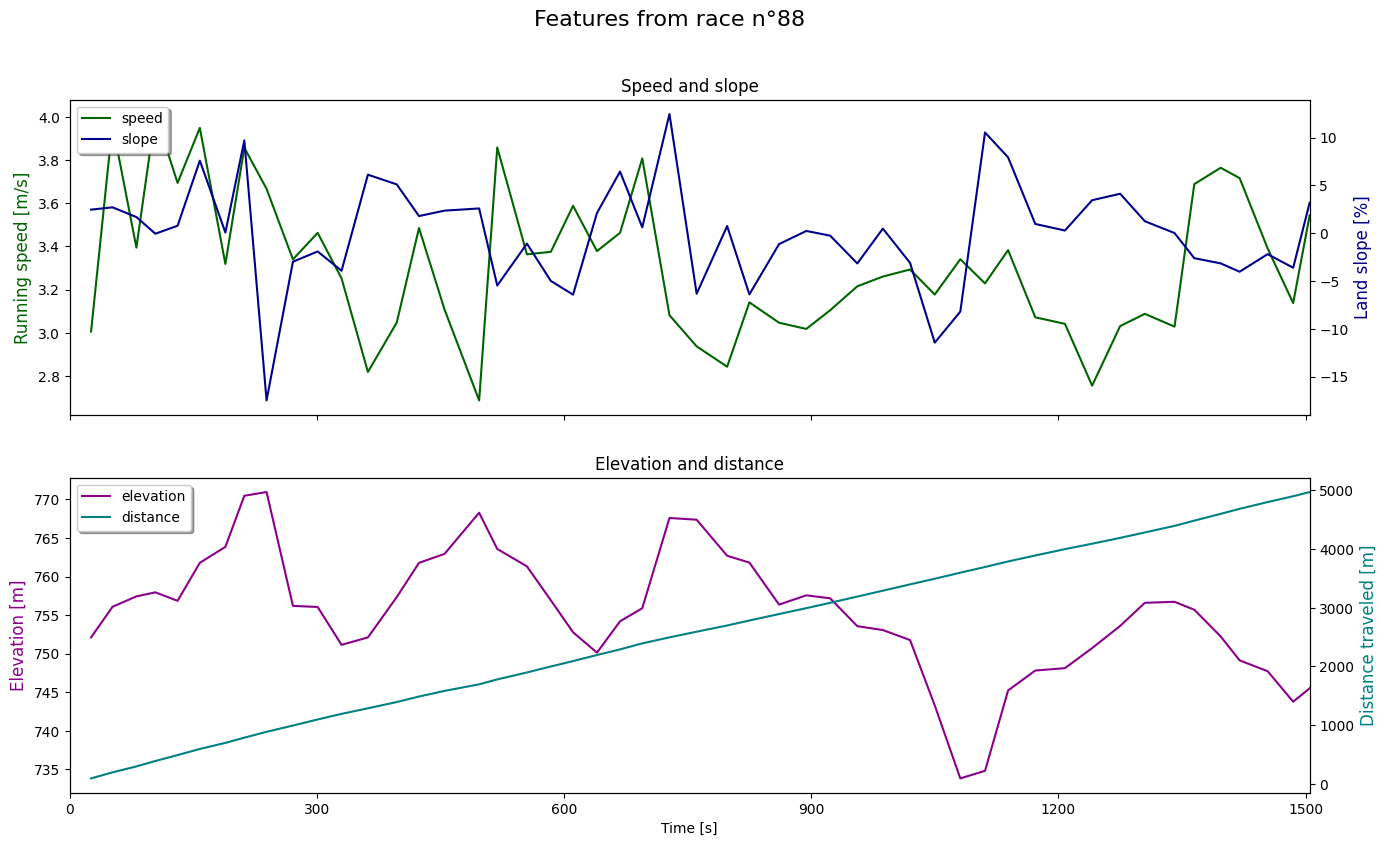

In [6]:
st.plot_race(dataset, np.random.randint(dataset['race'].max()))

### Normalize the dataset
The following cell normalizes the features into the interval [0, 1]

In [7]:
# Copy the dataset before normalisation, feature selection, numpy conversion, etc.
original_dataset = dataset.copy(deep=True)
min_speed = original_dataset['speed'].min()
max_speed = original_dataset['speed'].max()

#normalize only the selected features
#transform to numpy
normalized_dataset = dataset.filter(items=FEATURES).values
scaler = MinMaxScaler()
scaler.fit(normalized_dataset)
normalized_dataset = scaler.transform(normalized_dataset)
#transform back to dataframe
normalized_dataset = pd.DataFrame(normalized_dataset, index=dataset.index, columns=FEATURES)

#update the dataset with the new values
dataset.update(normalized_dataset)

print("Min (per features):", scaler.data_min_)
print("Max (per features):", scaler.data_max_)
display(dataset.head())

Min (per features): [  0.           0.         -23.19508109]
Max (per features): [7610.            7.86482054   27.56258073]


,time,elevation,distance,speed,slope,race
0,0.004731,747.640000,93.163136,0.286279,0.488956,0
1,0.010381,750.190909,199.194768,0.303141,0.532715,0
2,0.015637,752.112500,291.248444,0.287772,0.488903,0
3,0.021156,756.066667,390.345185,0.300415,0.509997,0
4,0.026150,756.975000,497.152039,0.357122,0.470889,0


### Create a training and a testing subset
Split the dataset into training and testing


In [8]:
TIMESTEPS = 25                   #define sequence length
TEST_SIZE = 0.2                  #value between ]0;1[
TRAINING_SIZE = 1 - TEST_SIZE

In [9]:
all_races = np.unique(dataset['race'])
print('Number of races', len(all_races))
RACES_TRAINING = int(np.floor(TRAINING_SIZE * len(all_races)))
races_train = np.random.choice(all_races, RACES_TRAINING, replace=False)
#print(races_train)
races_test = list(set(all_races) - set(races_train))
#print(races_test)
print(len(races_train), 'used during training --- Number of samples', np.sum(np.isin(dataset['race'], races_train)))
print(len(races_test), 'used during test\t --- Number of samples', np.sum(np.isin(dataset['race'], races_test)))

Number of races 230
184 used during training --- Number of samples 16611
46 used during test	 --- Number of samples 4057


### Create inputs and outputs
The folowing cell contains the function that will be used to create the inputs and outputs for training the models

In [10]:
#take a dataframe as input and return the splitted version with the prediction as a numpy array
def create_x_y(data, races):
  speed_index = data[FEATURES].columns.get_loc('speed') #get speed index
  slope_index = data[FEATURES].columns.get_loc('slope') #get slope index
  time_index = data[FEATURES].columns.get_loc('time') #get time index
  x = None
  y = None

  #iterate over every race
  for r in races:
    #filter race
    race_df = data.loc[data['race'] == r]
    #filter features
    race_np = race_df[FEATURES].values
    #split into timesteps (timesteps + 1 to take the target value)
    race_np = [race_np[i:(i+TIMESTEPS+1)] for i in range(race_np.shape[0] - (TIMESTEPS+2))]

    if len(race_np) == 0:
      print("Warning: not enough values in race", r)
      continue

    race_np = np.stack(race_np, axis=0)

    temp_x = np.dstack([race_np[:,1:,time_index],       # last TIMESTEPS-1 times and next time
                       race_np[:,1:,slope_index],       # last TIMESTEPS-1 slopes and next slope
                       race_np[:,:-1,speed_index]])     # last TIMESTEPS speeds
    temp_y = race_np[:,-1, speed_index]                 # next speed

    if x is None:
      x = temp_x
      y = temp_y
    else:
      x = np.append(x, temp_x, axis=0)
      y = np.append(y, temp_y, axis=0)

  return x, y

In [11]:
print('original shape:', dataset.shape)

X_train, y_train = create_x_y(dataset, races_train)
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)

X_test, y_test = create_x_y(dataset, races_test)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)


original shape: (20668, 6)
X_train shape: (11648, 25, 3)
y_train shape: (11648,)
X_test shape: (2819, 25, 3)
y_test shape: (2819,)


### Create a model and train it
The following cells create a LSTM network and train it with the training subset

In [12]:
BATCH_SIZE = 64          # Size of the batch for training
NB_EPOCHS = 60    # Number of times the training dataset is presented
NB_UNITS = 32         # Number of LSTM units

# Create and fit the LSTM network
model = Sequential()
model.add(LSTM(NB_UNITS, input_shape=(TIMESTEPS, len(FEATURES))))
#dense layer 1 : connect all LSTM cell to one cell -> output shape as (*, 1)
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 32)                4608      
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 4641 (18.13 KB)
Trainable params: 4641 (18.13 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [13]:
history = model.fit(X_train, y_train, epochs=NB_EPOCHS, batch_size=BATCH_SIZE, verbose=1, validation_data=(X_test, y_test))

Epoch 1/60
182/182 [==============================] - 6s 20ms/step - loss: 0.0137 - val_loss: 0.0023
Epoch 2/60
182/182 [==============================] - 2s 11ms/step - loss: 0.0020 - val_loss: 0.0017
Epoch 3/60
182/182 [==============================] - 2s 11ms/step - loss: 0.0017 - val_loss: 0.0016
Epoch 4/60
182/182 [==============================] - 2s 11ms/step - loss: 0.0015 - val_loss: 0.0014
Epoch 5/60
182/182 [==============================] - 2s 11ms/step - loss: 0.0014 - val_loss: 0.0012
Epoch 6/60
182/182 [==============================] - 3s 14ms/step - loss: 0.0014 - val_loss: 0.0013
Epoch 7/60
182/182 [==============================] - 3s 16ms/step - loss: 0.0014 - val_loss: 0.0011
Epoch 8/60
182/182 [==============================] - 2s 13ms/step - loss: 0.0013 - val_loss: 0.0012
Epoch 9/60
182/182 [==============================] - 2s 10ms/step - loss: 0.0013 - val_loss: 0.0011
Epoch 10/60
182/182 [==============================] - 2s 11ms/step - loss: 0.0013 - val_lo

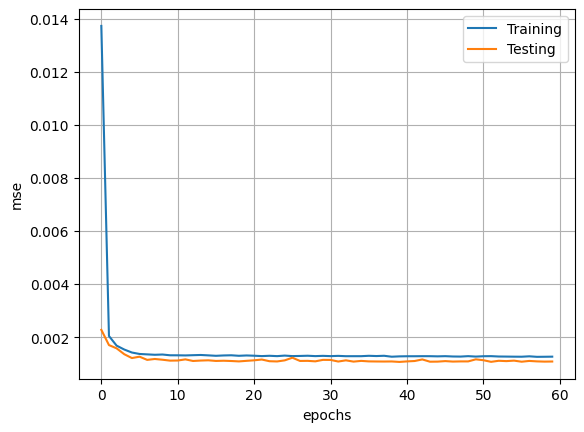

In [14]:
# Plot the training and testing
pl.plot(history.history['loss'], label='Training')
pl.plot(history.history['val_loss'], label='Testing')
pl.xlabel('epochs')
pl.ylabel('mse')
pl.legend()
pl.grid()

### Evaluate the performance of the model
The following cell computes the correlation between the actual speed of the runner and the model's output

In [15]:
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

print('Training correlation coefficient:', np.corrcoef(y_train.T, y_train_pred.T)[0,1])
print('Test correlation coefficient:', np.corrcoef(y_test.T, y_test_pred.T)[0,1])

89/89 [==============================] - 1s 4ms/step
Training correlation coefficient: 0.6546829706537176
Test correlation coefficient: 0.7156412199181862


### Visualize the results
The following cell visualize the output of the LSTM for a single race in the testing subset and compare it with the actual speed of the runner

3/3 [==============================] - 0s 9ms/step
Mean Absolute Error for race number 148: 0.1856309930595739


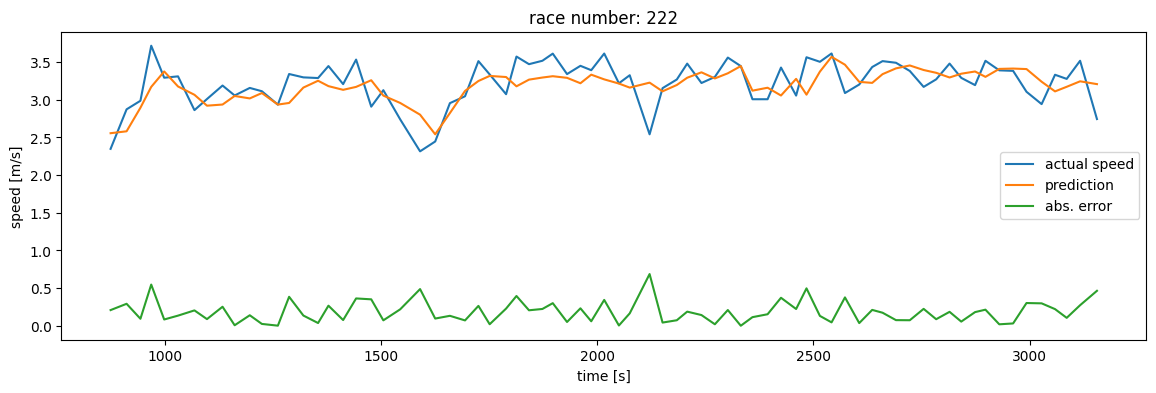

In [23]:
random_race = np.random.choice(races_test)
X, y = create_x_y(dataset, [random_race])
X_o, y_o = create_x_y(original_dataset, [random_race])            # select inputs and output from the unnormalized dataset also

y_pred_o = model.predict(X) * (max_speed - min_speed) + min_speed # unnormalize the prediction

pl.figure(figsize=(14,4))
pl.plot(X_o[:,-1,0], y_o, label='actual speed')
pl.plot(X_o[:,-1,0], y_pred_o, label='prediction')
pl.plot(X_o[:,-1,0], np.abs(y_o - y_pred_o[:,0]), label='abs. error')
pl.legend()
pl.title('race number: ' + str(random_race))
pl.xlabel('time [s]')
pl.ylabel('speed [m/s]');

mae = np.mean(np.abs(y_o - y_pred_o[:,0]))
print(f"Mean Absolute Error for race number {random_race}: {mae}")

# Exercise

1. Change the number of units and epochs of the LSTM network. Show the configuration that performed the best.
2. What is the largest error (speed prediction) you observed? Do you observe that most of those large errors show up for high speeds ? or low speeds? Why?
3. Using the predicted speeds for a given race, compute the expected time for a race and compute the difference between the real race time and the predicted race time in minutes. Provide the code of the cell that computes this prediction error.

In [20]:
def calculate_segment_distances(speeds, times):
    """ Calculate approximate distance for each race segment. """
    # Calculate the time difference between consecutive points
    time_diffs = np.diff(times)
    # Approximate distance for each segment
    distances = speeds[:-1] * time_diffs
    return distances

# Extract time and speeds from the dataset
times = X_o[:,-1,0]  # time in seconds
real_speeds = y_o
predicted_speeds = y_pred_o[:,0]

# Calculate distances for each segment
segment_distances = calculate_segment_distances(real_speeds, times)

# Calculate race times using these distances
real_race_time = np.sum(segment_distances / real_speeds[:-1]) / 60  # Convert to minutes
predicted_race_time = np.sum(segment_distances / predicted_speeds[:-1]) / 60

prediction_error = (real_race_time - predicted_race_time) / real_race_time * 100  # Percentage error

print(f"Real Race Time: {real_race_time:.2f} minutes")
print(f"Predicted Race Time: {predicted_race_time:.2f} minutes")
print(f"Prediction Error: {prediction_error:.2f}%")
print(f"Max MSE error: {np.abs(y_o - y_pred_o[:,0]).max()}")

Real Race Time: 38.03 minutes
Predicted Race Time: 38.59 minutes
Prediction Error: -1.47%
Max MSE error: 0.6864103995451498
